## Start Notebook


In [2]:
import json
import logging
import os
import random
import warnings

import keras_tuner
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import layers as tfkl
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow import keras as tfk

2023-12-19 09:19:56.876540: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-19 09:19:56.903218: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 09:19:56.903241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 09:19:56.904008: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 09:19:56.908518: I tensorflow/core/platform/cpu_feature_guar

### Hide warnings


In [3]:
# hide warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["MPLCONFIGDIR"] = os.getcwd() + "/configs/"

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# show version and GPU info
print("TF version:", tf.__version__)
print("TF built with CUDA:", tf.test.is_built_with_cuda())
print("TF GPU:", tf.config.list_physical_devices("GPU"))

TF version: 2.15.0
TF built with CUDA: True
TF GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Set variables


In [4]:
# set random seeds
seed = 42

# length of the input sequence
window = 200
# length of the prediction sequence
telescope = 9
# length of the stride for the sliding window
stride = 40

# folder containing the .npy files
data_folder = "data"
# folder containing the trained models
models_folder = "models"
# folder containing the tuned models
tuned_models_folder = "tuned_models"
# folder containing the tuning logs
tuner_folder = "tuner"

# batch size for training
batch_size = 64
# number of epochs for training
epochs = 400
# number of epochs for tuning
tune_epochs = 10
# split ratio for train/test
test_split = 0.1
# split ratio for train/validation
validation_split = 0.1
# tune dataset size
tune_dataset_size = 0.25
# if true, the single model will be trained
train_single_model = True
# if true, the models on the class will be trained
train_class_models = True

### Sanity checks


In [5]:
assert os.path.exists(data_folder), "Data folder not found."
assert window % stride == 0, "Window must be divisible by stride."
assert (
    test_split + validation_split < 1,
), "Test and validation split must be less than 1."
assert (
    test_split > 0 and validation_split > 0,
), "Test and validation split must be greater than 0."
assert train_single_model or train_class_models, "No model to train."


# check if the tuner folder exists and it is not empty
if os.path.exists(tuner_folder) and os.listdir(tuner_folder):
    print("Tuner folder is not empty! New models will not be tuned.")

# check if tf is using GPU
if not tf.config.list_physical_devices("GPU"):
    print("No GPU found! Training will be slow.")

if not os.path.exists(models_folder):
    os.makedirs(models_folder)

if not os.path.exists(tuned_models_folder):
    os.makedirs(tuned_models_folder)

Tuner folder is not empty! New models will not be tuned.


### Set seeds

In [6]:
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

### Useful functions

In [7]:
def get_model_path(category: str) -> str:
    """Returns the path of the model for the given category."""
    return os.path.join(models_folder, f"model_{category}.h5")


def get_history_path(category: str = None) -> str:
    """Returns the path of the history for the given category."""
    if category is None:
        category = "all"
    return os.path.join(models_folder, f"history_{category}.json")


def get_tuned_model_path(category: str = None) -> str:
    """Returns the path of the tuned model for the given category."""
    if category is None:
        category = "all"
    return os.path.join(tuned_models_folder, f"tuned_model_{category}.h5")


def get_category_name(x: int | str) -> str:
    """Returns the name of the category for the given index."""
    if x == "single_category":
        return "single_category"

    return chr(ord("A") + x)

## Load Data


In [8]:
categories = np.load(f"{data_folder}/categories.npy")
training_data = np.load(f"{data_folder}/training_data.npy")
valid_periods = np.load(f"{data_folder}/valid_periods.npy")

unique_categories = np.unique(categories)

print(f"Categories: {categories.shape}, labels: {unique_categories}")
print(f"Training data: {training_data.shape}")
print(f"Length of each time series in training data: {training_data.shape[1]}")
print(f"Validation periods: {valid_periods.shape}")

Categories: (48000,), labels: ['A' 'B' 'C' 'D' 'E' 'F']
Training data: (48000, 2776)
Length of each time series in training data: 2776
Validation periods: (48000, 2)


### Clean Data and Split into categories


Category A: 46820 time series for training, 523 time series for testing.
Category B: 36930 time series for training, 432 time series for testing.
Category C: 56320 time series for training, 584 time series for testing.
Category D: 60590 time series for training, 642 time series for testing.
Category E: 41000 time series for training, 446 time series for testing.
Category F: 1240 time series for training, 14 time series for testing.
Category single_category: 242900 time series for training, 2641 time series for testing.
Input shape: (200, 1), output shape: (9, 1)


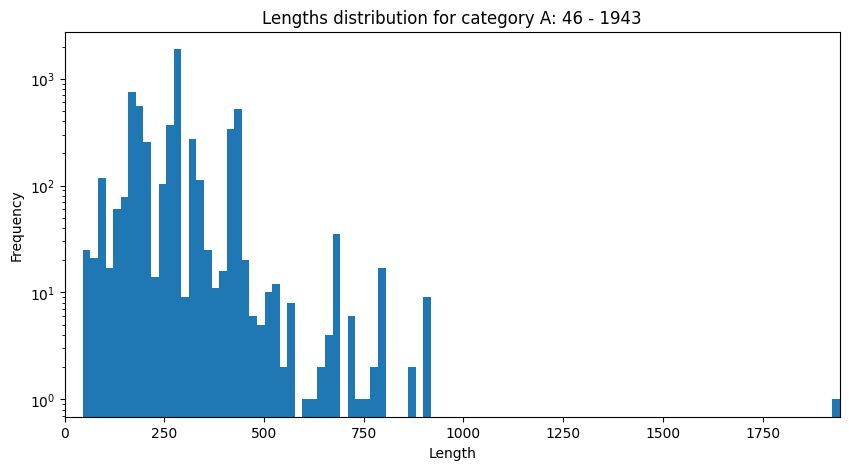

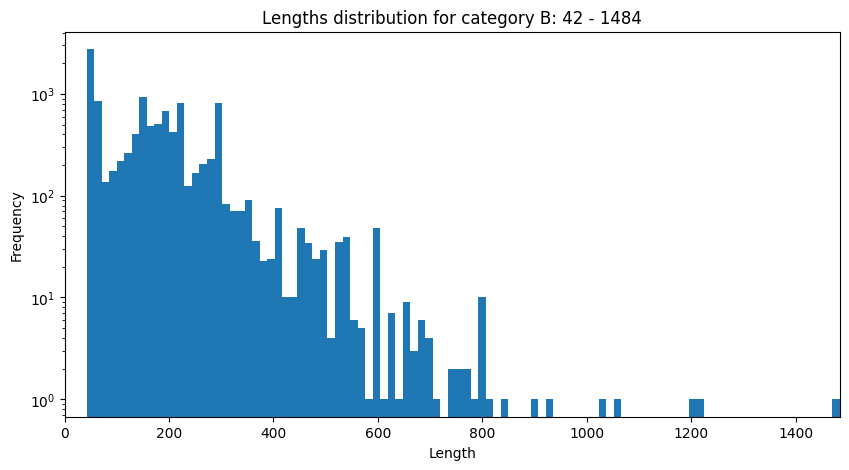

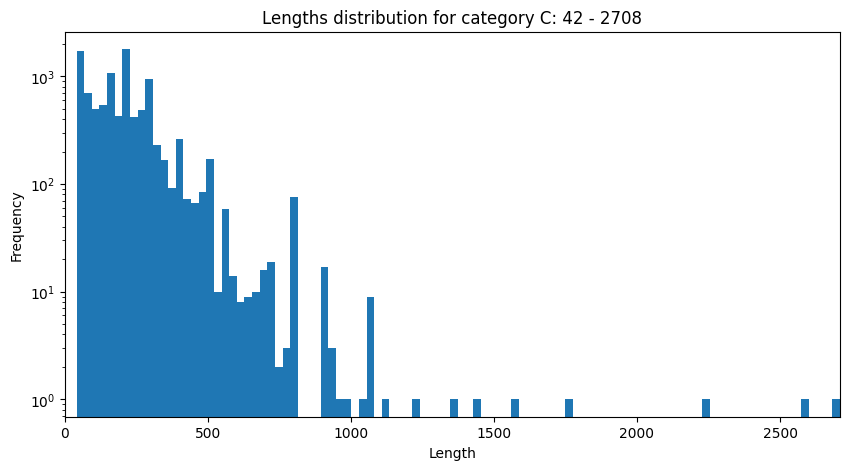

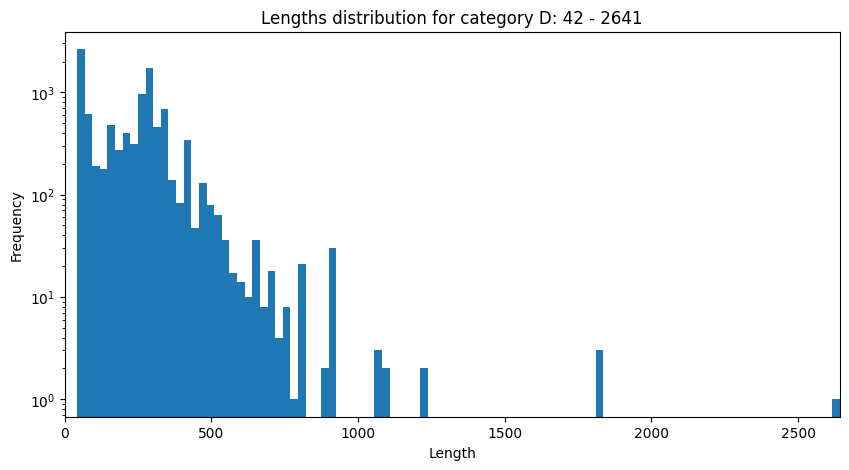

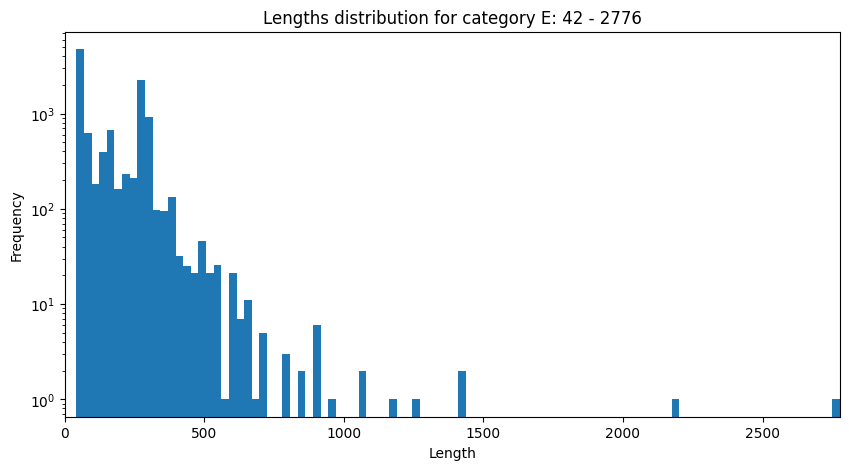

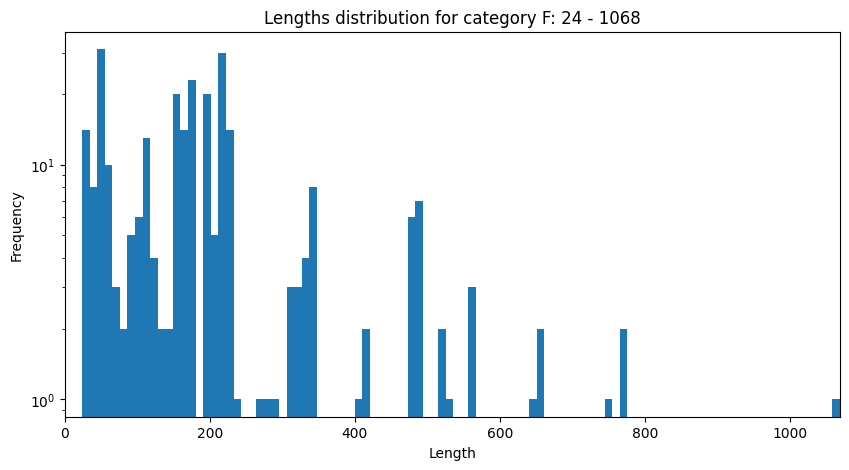

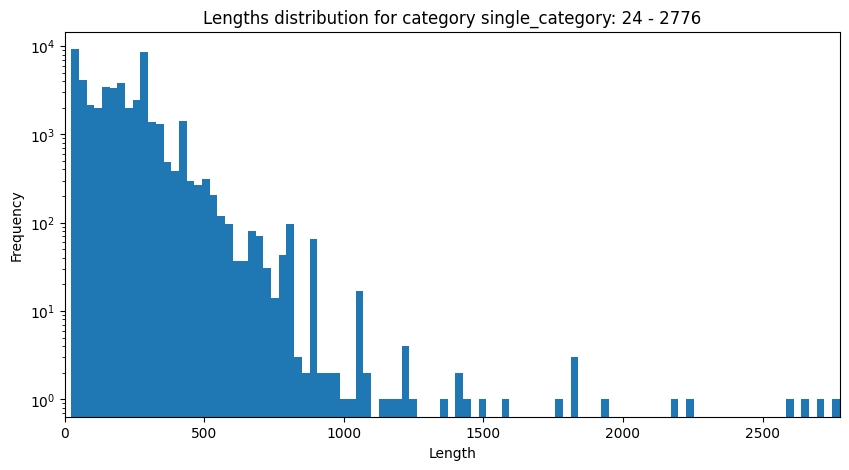

In [12]:
def build_sequences(
    serie: np.array,
    window: int = 200,
    stride: int = 20,
    telescope: int = 9,
) -> tuple[np.array, np.array]:
    dataset = []
    labels = []

    current_data = serie.copy()
    current_label = serie.copy()

    # check if the serie is divisible by window
    if len(serie) % window != 0:
        # Compute padding length
        padding_len = window - len(serie) % window
        padding = np.zeros((padding_len), dtype="float32")

        current_data = np.concatenate((padding, serie))
        current_label = np.concatenate((padding, current_label))

    # Split the serie into multiple of len window
    for x in np.arange(0, len(current_data) - window - telescope, stride):
        dataset.append(current_data[x : x + window])
        labels.append(current_label[x + window : x + window + telescope])

    # convert to numpy array
    dataset = np.array(dataset)
    labels = np.array(labels)

    return dataset, labels


def build_dict(
    category: str,
    data: np.array,
    categories: np.array,
    test_split: float,
) -> dict:
    # create lists
    X_train, Y_train = [], []
    X_test, Y_test = [], []
    lengths = []

    # find indices of the current category
    indices = np.where(categories == category)[0]
    # calculate split point
    split_point = int(len(indices) * test_split)
    # shuffle the indices
    np.random.shuffle(indices)

    # iterate over the indices
    for i in range(len(indices)):
        # get the start and end of the period
        start, end = valid_periods[indices[i]]
        # get the series
        series = data[indices[i], start:end]
        # append the length
        lengths.append(len(series))

        # split the data
        if i < split_point:
            # build the sequence for the test set
            x, y = build_sequences(
                series,
                stride=window,
                window=window,
                telescope=telescope * 2,
            )
            X_test.extend(x)
            Y_test.extend(y)
        else:
            # build the sequence for the training set
            x, y = build_sequences(
                series,
                telescope=telescope,
                window=window,
            )
            X_train.extend(x)
            Y_train.extend(y)

    # convert to numpy array
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)

    # convert to numpy array
    return {
        "X_train": np.expand_dims(X_train, axis=-1),
        "Y_train": np.expand_dims(Y_train, axis=-1),
        "X_test": np.expand_dims(X_test, axis=-1),
        "Y_test": np.expand_dims(Y_test, axis=-1),
        "lengths": np.array(lengths),
    }


def merge_datasets(datasets: dict) -> dict:
    # create empty lists
    X_train, Y_train = [], []
    X_test, Y_test = [], []

    # iterate over the datasets
    for dataset in datasets.values():
        X_train.extend(dataset["X_train"])
        Y_train.extend(dataset["Y_train"])
        X_test.extend(dataset["X_test"])
        Y_test.extend(dataset["Y_test"])

    # convert to numpy array
    merged = {
        "X_train": np.array(X_train),
        "Y_train": np.array(Y_train),
        "X_test": np.array(X_test),
        "Y_test": np.array(Y_test),
        "lengths": np.concatenate([d["lengths"] for d in datasets.values()]),
    }
    return merged


def plot_lengths_distribution(category: str, dataset: dict) -> None:
    # search for the maximum and minimum length
    min_len, max_len = np.min(dataset["lengths"]), np.max(dataset["lengths"])
    # create the figure
    plt.figure(figsize=(10, 5))
    # iterate over the datasets
    plt.hist(dataset["lengths"], bins=100)
    # set the title
    plt.title(f"Lengths distribution for category {category}: {min_len} - {max_len}")
    # set the x axis
    plt.xlabel("Length")
    plt.xlim(0, max_len)
    # set the y axis
    plt.ylabel("Frequency")
    plt.yscale("log")
    # show the plot
    plt.show()


# build the dictionary
dataset = {
    c: build_dict(c, training_data, categories, test_split) for c in unique_categories
}
dataset["single_category"] = merge_datasets(dataset)

# print the size of the dataset
for k, v in dataset.items():
    print(
        f"Category {k}: {v['X_train'].shape[0]} time series for training, "
        f"{v['X_test'].shape[0]} time series for testing."
    )

# compute input and output shapes
input_shape = dataset["A"]["X_train"].shape[1:]
output_shape = dataset["A"]["Y_train"].shape[1:]
print(f"Input shape: {input_shape}, output shape: {output_shape}")

# plot the lengths distribution
for k, v in dataset.items():
    plot_lengths_distribution(k, v)

### Compute autocorrelation for each time series

In [13]:
def extract_series(
    category: str,
    data: np.array,
    categories: np.array,
) -> np.array:
    x = []
    indices = np.where(categories == category)[0]

    for i in range(len(indices)):
        start, end = valid_periods[indices[i]]
        series = data[indices[i], start:end]

        x.append(series)

    return x


def autocorrelation(serie: np.array) -> np.array:
    # compute and normalize the autocorrelation
    a = np.correlate(serie, serie, mode="full")[len(serie) :]
    a /= np.max(a)
    # compute the fourier transform of the autocorrelation
    f = np.fft.fft(a)[0 : len(a) // 2]
    return a, f


autocorrelations = {}
for category in unique_categories:
    autocorrelations[category] = []
    series = extract_series(category, training_data, categories)

    print(f"Computing autocorrelation for {category}")
    for x, serie in enumerate(series):
        a, f = autocorrelation(serie)
        # create a dictionary with the autocorrelation and the fourier transform
        autocorrelations[category].append(
            {
                "autocorrelation": a,
                "fourier_autocorrelation": f,
                "serie": serie,
                "dominant_frequency": np.argmax(f[1:]) + 1,
            }
        )
print("All autocorrelations computed.")

Computing autocorrelation for A
Computing autocorrelation for B
Computing autocorrelation for C
Computing autocorrelation for D
Computing autocorrelation for E
Computing autocorrelation for F
All autocorrelations computed.


### Plot autocorrelation

Category: F, index: 57, dominant frequency: 1


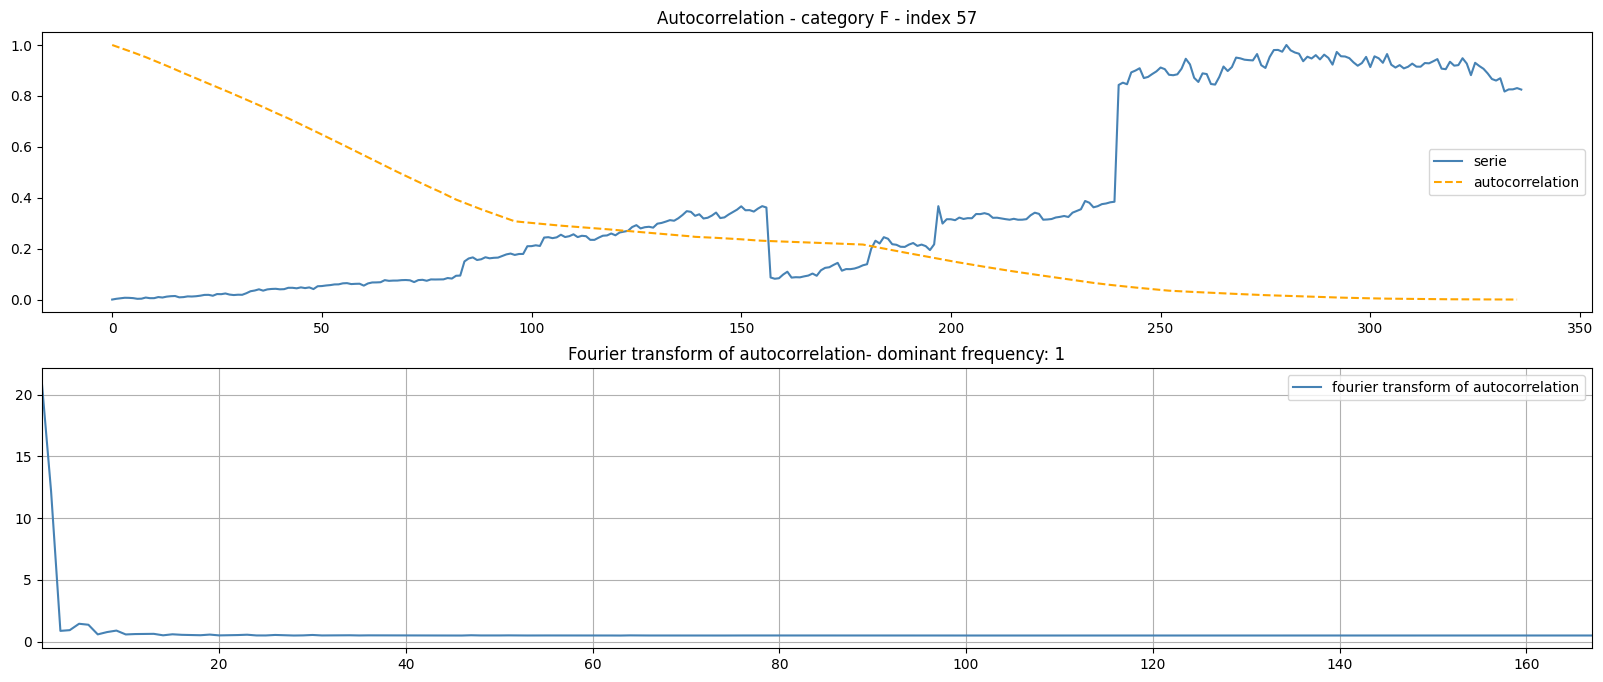

In [49]:
def plot_autocorrelation(series: dict, category: str, index: int):
    # create the figure
    plt.figure(figsize=(20, 8))
    # first subplot: serie and autocorrelation
    plt.subplot(2, 1, 1)
    plt.title(f"Autocorrelation - category {category} - index {index}")
    plt.plot(series["serie"], label="serie", color="steelblue")
    plt.plot(
        series["autocorrelation"],
        label="autocorrelation",
        linestyle="--",
        color="orange",
    )
    plt.legend()

    # second subplot: fourier transform of autocorrelation
    plt.subplot(2, 1, 2)
    plt.title(
        f"Fourier transform of autocorrelation"
        f"- dominant frequency: {series['dominant_frequency']}"
    )
    y = series["fourier_autocorrelation"][1:]
    x = np.arange(1, len(y) + 1)
    plt.plot(
        x,
        y,
        label="fourier transform of autocorrelation",
        color="steelblue",
    )
    plt.xlim([1, len(y)])

    plt.legend()
    plt.grid()

    plt.show()


category = random.choice(list(autocorrelations.keys()))
index = random.randint(0, len(autocorrelations[category]))
series = autocorrelations[category][index]

print(
    f"Category: {category}, index: {index}, "
    f"dominant frequency: {series['dominant_frequency']}"
)
plot_autocorrelation(series, category, index)

### Show data


Category A: train (46820, 200, 1), test (523, 200, 1)
Category B: train (36930, 200, 1), test (432, 200, 1)
Category C: train (56320, 200, 1), test (584, 200, 1)
Category D: train (60590, 200, 1), test (642, 200, 1)
Category E: train (41000, 200, 1), test (446, 200, 1)
Category F: train (1240, 200, 1), test (14, 200, 1)


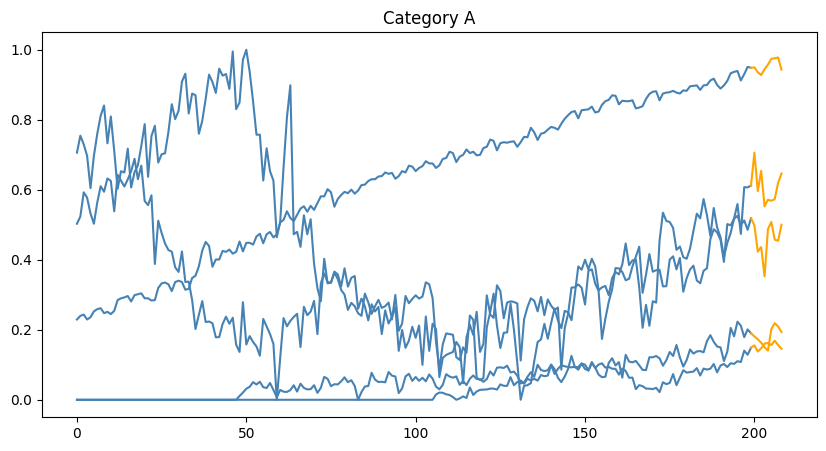

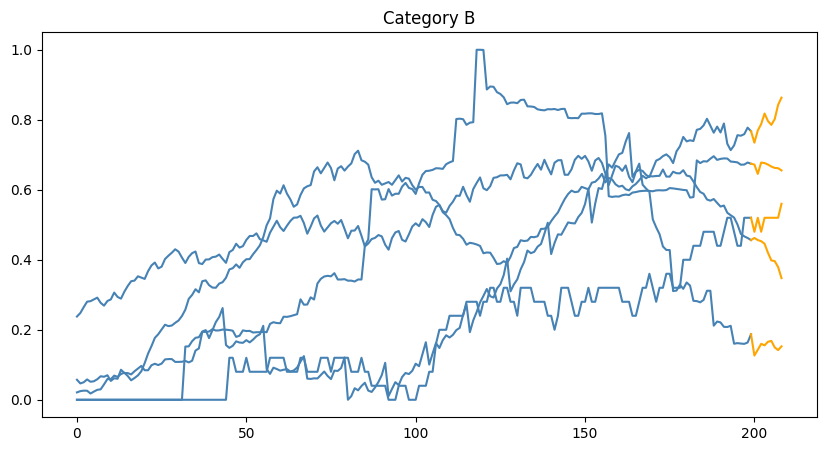

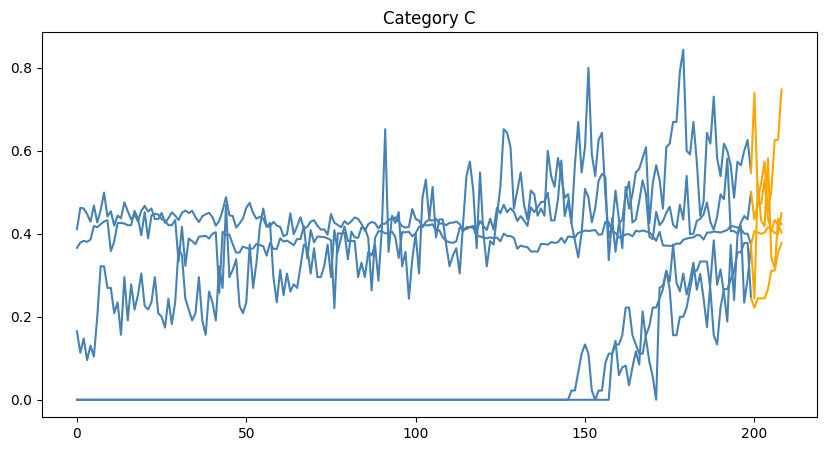

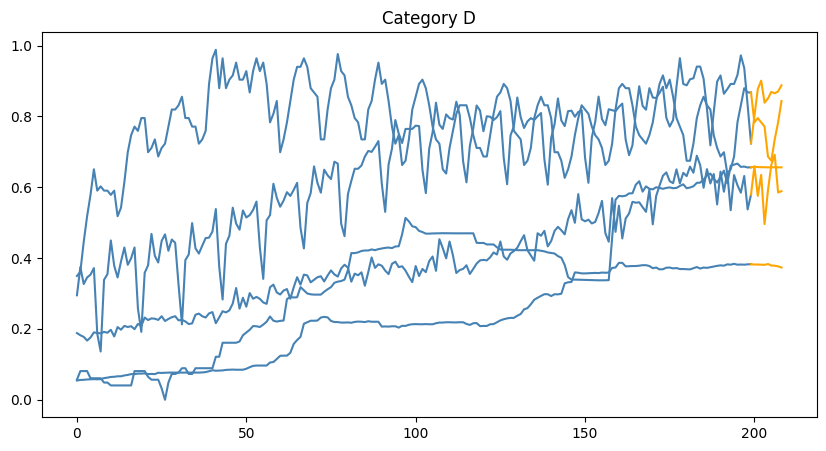

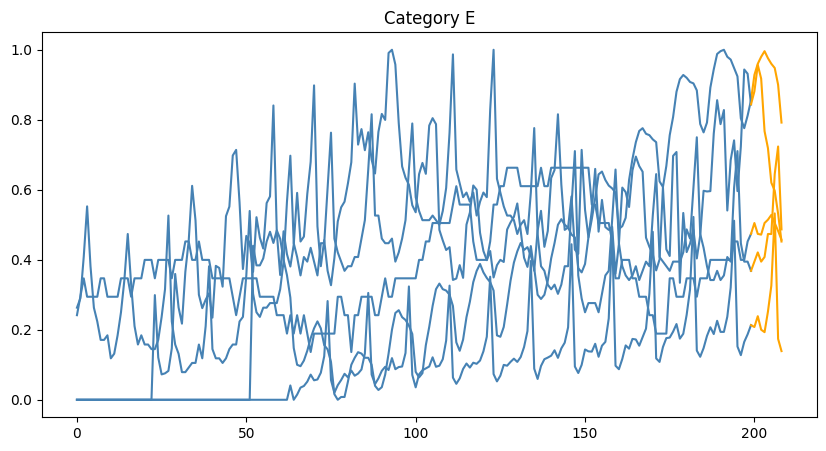

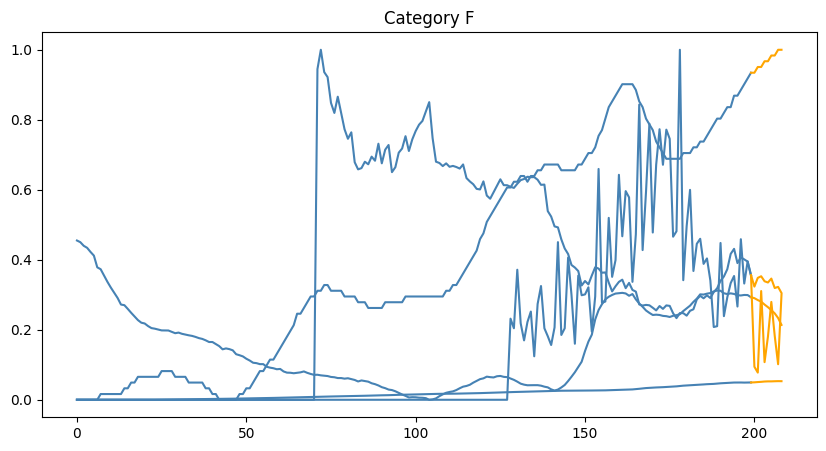

Total: train 242900, test 2641
Input shape: (200, 1)
Output shape: (9, 1)


In [14]:
def plot_train_data(x: np.array, y: np.array, title: str, n: int = 5):
    plt.figure(figsize=(10, 5))
    plt.title(title)

    for _ in range(n):
        i = random.randint(0, len(x) - 1)
        plt.plot(x[i], color="steelblue")

        # Create a new X-axis for y that starts from the end of x and extends to the length of y
        y_x_axis = np.arange(len(x[i]) - 1, len(x[i]) + len(y[i]))
        # Concatenate the last point of x with y
        y_values = np.concatenate([x[i][-1:], y[i]])
        plt.plot(y_x_axis, y_values, color="orange")

    plt.show()


total_train = 0
total_test = 0
for category in unique_categories:
    print(
        f"Category {category}: train {dataset[category]['X_train'].shape}, "
        f"test {dataset[category]['X_test'].shape}"
    )
    total_train += dataset[category]["X_train"].shape[0]
    total_test += dataset[category]["X_test"].shape[0]


for category in unique_categories:
    plot_train_data(
        dataset[category]["X_train"],
        dataset[category]["Y_train"],
        f"Category {category}",
    )

print(f"Total: train {total_train}, test {total_test}")

print(f"Input shape: {input_shape}")
print(f"Output shape: {output_shape}")

## Define Model


In [51]:
def build_model(hp: HyperParameters) -> tfk.Model:
    # unpack hyperparameters
    conv1_filters = hp.Choice(
        "conv1_filters", [32, 64, 128, 256, 512, 1024], default=64
    )
    conv2_filters = hp.Choice(
        "conv2_filters", [32, 64, 128, 256, 512, 1024], default=128
    )
    lstm_units = hp.Choice("lstm_units", [128, 256, 512, 1024], default=512)

    input_layer = tfkl.Input(shape=input_shape, name="Input")

    x = input_layer

    x = tfkl.BatchNormalization()(x)
    x = tfkl.GaussianNoise(stddev=0.015, seed=seed)(x)

    x = tfkl.Conv1D(
        filters=conv1_filters,
        kernel_size=3,
        padding="valid",
        activation="relu",
        name="Conv1D_1",
    )(input_layer)
    x = tfkl.Conv1D(
        filters=conv2_filters,
        kernel_size=3,
        padding="valid",
        activation="relu",
        name="Conv1D_2",
    )(x)
    x = tfkl.MaxPool1D(name="MaxPool1D_1")(x)

    lstm = tfkl.LSTM(
        units=lstm_units,
        return_sequences=True,
        return_state=False,
        name="LSTM_1",
    )(x)

    attention = tfkl.Dense(1, name="Dense_attention_1")(lstm)
    attention = tfkl.Flatten()(attention)
    attention = tfkl.Activation("softmax")(attention)
    attention = tfkl.RepeatVector(lstm_units)(attention)
    attention = tfkl.Permute([2, 1])(attention)
    attention = tfkl.Multiply()([lstm, attention])
    attention = tfkl.Lambda(lambda x: tf.reduce_sum(x, axis=1))(attention)

    output_layer = tfkl.Dense(output_shape[0])(attention)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name="conv_LSTM_model")

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(
        loss="mse",
        optimizer="adam",
        metrics=["mae", "mse"],
    )

    return model

### Tune Model

In [52]:
def tune_model(dataset: dict[str]) -> tuple[tfk.Model, keras_tuner.HyperParameters]:
    tuner = keras_tuner.tuners.BayesianOptimization(
        build_model,
        objective="val_loss",
        seed=seed,
        directory=tuner_folder,
        project_name="conv_LSTM",
    )

    # tune model on a subset of the data
    indices = np.random.choice(
        np.arange(dataset["X_train"].shape[0]),
        size=int(dataset["X_train"].shape[0] * tune_dataset_size),
        replace=False,
    )

    # extract the subset
    x = dataset["X_train"][indices]
    y = dataset["Y_train"][indices]

    tuner.search(
        x=x,
        y=y,
        epochs=tune_epochs,
        batch_size=batch_size,
        validation_split=validation_split,
    )

    # get the best model
    best_model = tuner.get_best_models(num_models=1)[0]
    best_parameters = tuner.get_best_hyperparameters(num_trials=1)[0]
    return (best_model, best_parameters)


# tune the model
tuned_model, tuned_parameters = tune_model(dataset["single_category"])
# show the best parameters
tuned_model.summary()
print(tuned_parameters.values)

Trial 10 Complete [00h 06m 42s]
val_loss: 0.006056328769773245

Best val_loss So Far: 0.006056328769773245
Total elapsed time: 00h 51m 52s
Model: "conv_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 200, 1)]             0         []                            
                                                                                                  
 Conv1D_1 (Conv1D)           (None, 198, 256)             1024      ['Input[0][0]']               
                                                                                                  
 Conv1D_2 (Conv1D)           (None, 196, 1024)            787456    ['Conv1D_1[0][0]']            
                                                                                                  
 MaxPool1D_1 (MaxPooling1D)  (None, 98, 1024

#### Save tuned models and parameters to disk

In [53]:
# save the model
tuned_path = get_tuned_model_path()
tuned_model.save(tuned_path)
# save the parameters for future reference
with open(f"{tuned_path}-values.json", "w") as f:
    json.dump(tuned_parameters.values, f, indent=4, sort_keys=True)
with open(f"{tuned_path}-config.json", "w") as f:
    json.dump(tuned_parameters.get_config(), f, indent=4, sort_keys=True)

#### Load tuned models

In [15]:
# load category models
tuned_path = get_tuned_model_path()
model_list = []
single_category_model = None

if train_class_models:
    for category in unique_categories:
        print(f"Loading model for category {category} from {tuned_path}...")
        model_list.append(tfk.models.load_model(tuned_path))

# load single model
if train_single_model:
    print(f"Loading single model from {tuned_path}...")
    single_category_model = tfk.models.load_model(tuned_path)

Loading model for category A from tuned_models/tuned_model_all.h5...


2023-12-19 09:22:20.409521: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4279 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Loading model for category B from tuned_models/tuned_model_all.h5...
Loading model for category C from tuned_models/tuned_model_all.h5...
Loading model for category D from tuned_models/tuned_model_all.h5...
Loading model for category E from tuned_models/tuned_model_all.h5...
Loading model for category F from tuned_models/tuned_model_all.h5...
Loading single model from tuned_models/tuned_model_all.h5...


### Train Model


In [55]:
def train_model(
    model: tfk.Model,
    dataset: np.array,
    category: str,
    epochs: int = 100,
) -> tfk.Model:
    if category in dataset.keys():
        x = dataset[category]["X_train"]
        y = dataset[category]["Y_train"]
    else:
        x = dataset["X_train"]
        y = dataset["Y_train"]

    callbacks = [
        tfk.callbacks.EarlyStopping(
            monitor="val_loss",
            mode="min",
            patience=20,
            restore_best_weights=True,
            verbose=1,
        ),
        tfk.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            mode="min",
            patience=5,
            factor=0.5,
            min_lr=1e-7,
            verbose=1,
        ),
    ]

    print(f"Training model for category {category}")
    print(model.summary())
    history = model.fit(
        x=x,
        y=y,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=validation_split,
        callbacks=callbacks,
    ).history
    # Save the model
    return history


# train the models for each category
history_list = []
if train_class_models:
    for s, category in enumerate(unique_categories):
        history = train_model(
            model=model_list[s],
            dataset=dataset,
            category=category,
            epochs=epochs,
        )
        history_list.append(history)

# train the single category model
if train_single_model:
    single_category_history = train_model(
        model=single_category_model,
        dataset=dataset,
        category="single_category",
        epochs=epochs,
    )

print("Training completed.")

Training model for category A
Model: "conv_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 200, 1)]             0         []                            
                                                                                                  
 Conv1D_1 (Conv1D)           (None, 198, 256)             1024      ['Input[0][0]']               
                                                                                                  
 Conv1D_2 (Conv1D)           (None, 196, 1024)            787456    ['Conv1D_1[0][0]']            
                                                                                                  
 MaxPool1D_1 (MaxPooling1D)  (None, 98, 1024)             0         ['Conv1D_2[0][0]']            
                                                      

#### Save trained models and trained history to disk

In [77]:
if train_class_models:
    for x, c in enumerate(unique_categories):
        model_path = get_model_path(c)
        model_list[x].save(model_path)

        history_path = get_history_path(c)
        with open(history_path, "w") as f:
            json.dump(history_list[x], f, indent=4, sort_keys=True)

if train_single_model:
    model_path = get_model_path("single_category")
    single_category_model.save(model_path)

    history_path = get_history_path()
    with open(history_path, "w") as f:
        json.dump(single_category_history, f, indent=4, sort_keys=True)

Model for category A saved at models/model_A.h5
Model for category B saved at models/model_B.h5
Model for category C saved at models/model_C.h5
Model for category D saved at models/model_D.h5
Model for category E saved at models/model_E.h5
Model for category F saved at models/model_F.h5


NameError: name 'history_list' is not defined

### Plot training history


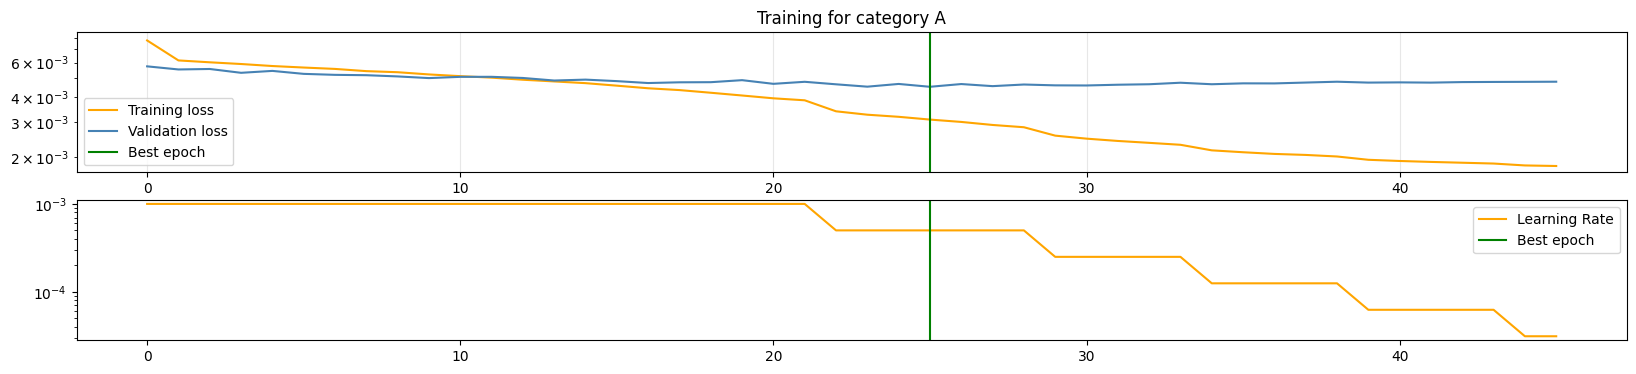

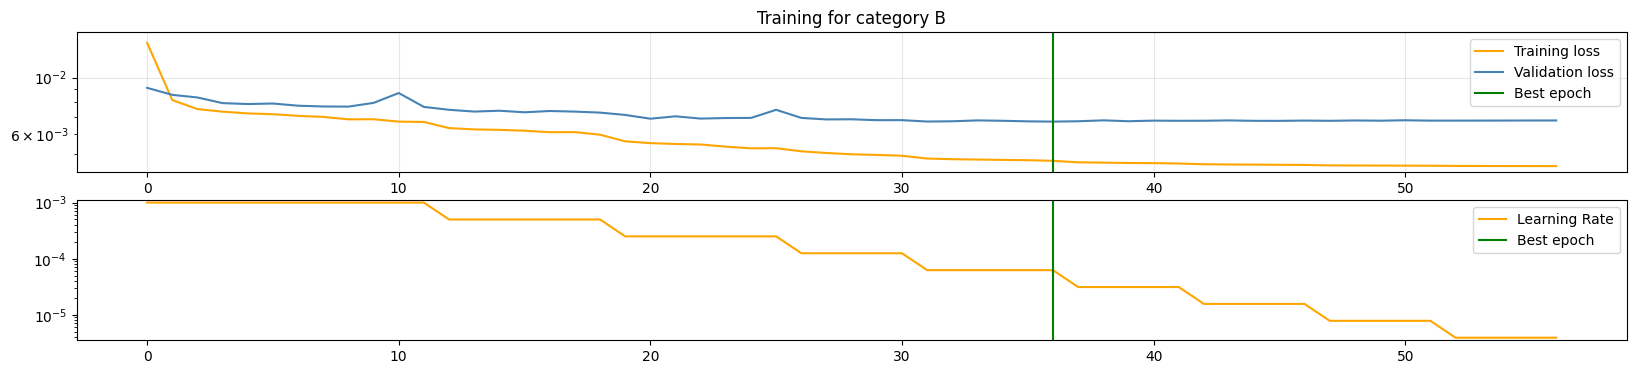

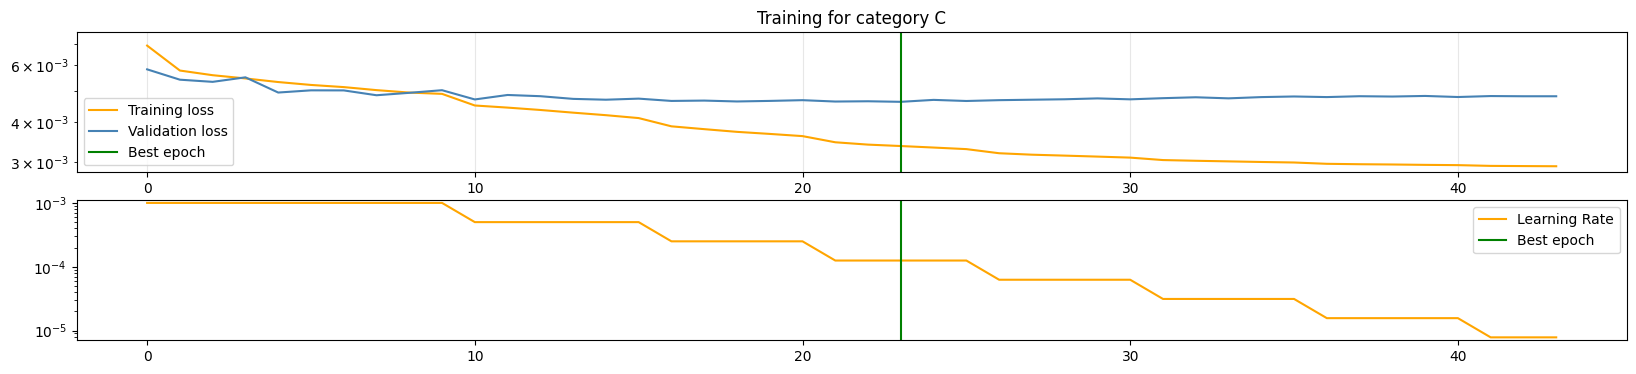

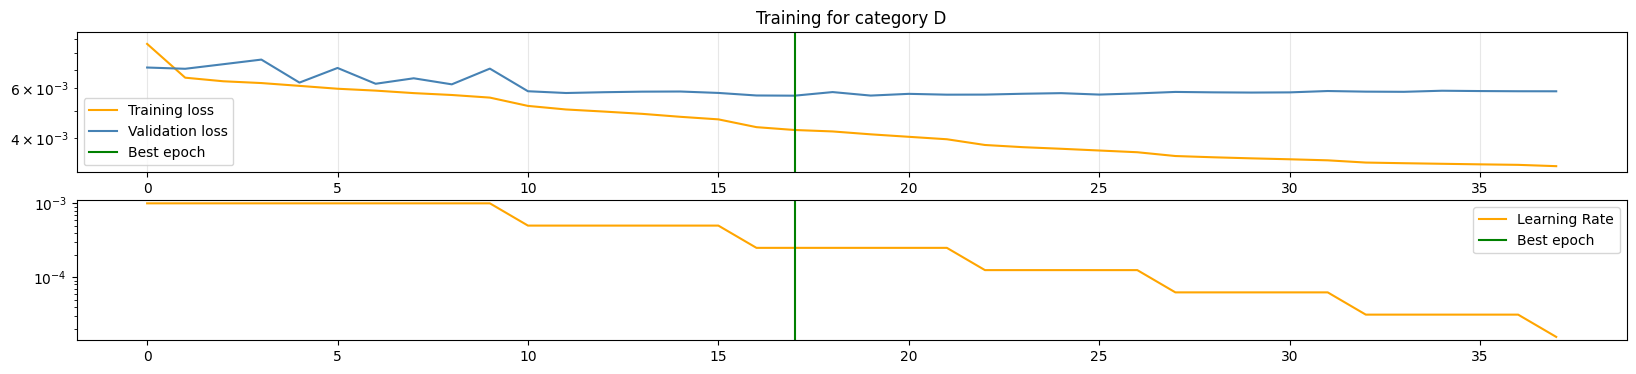

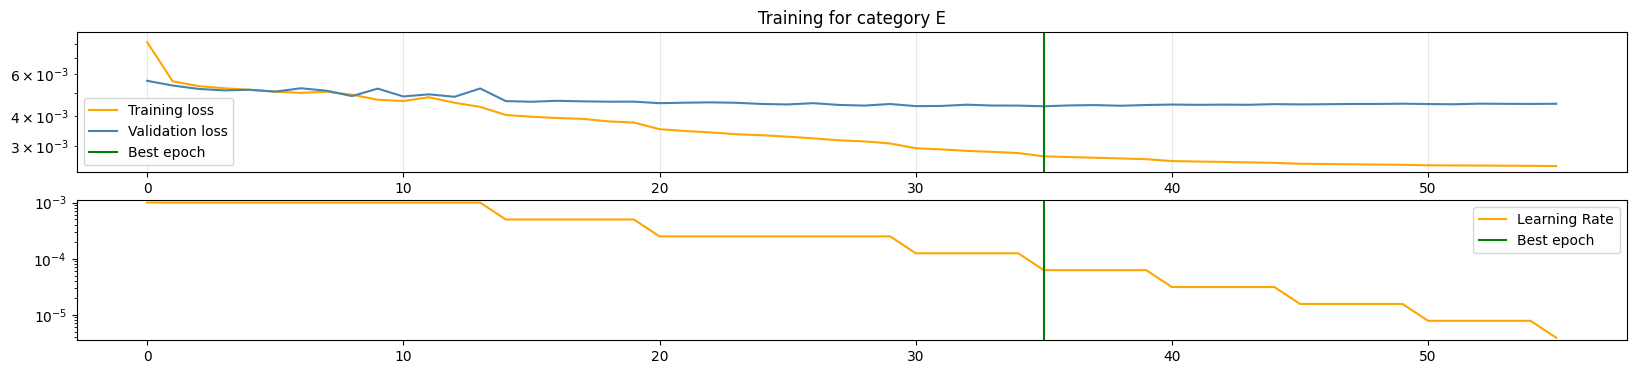

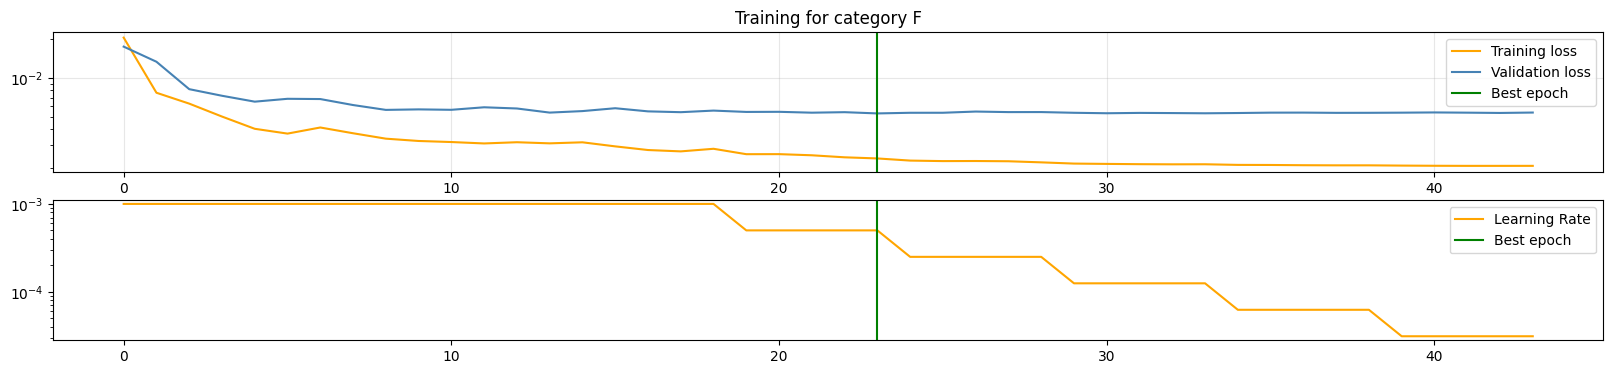

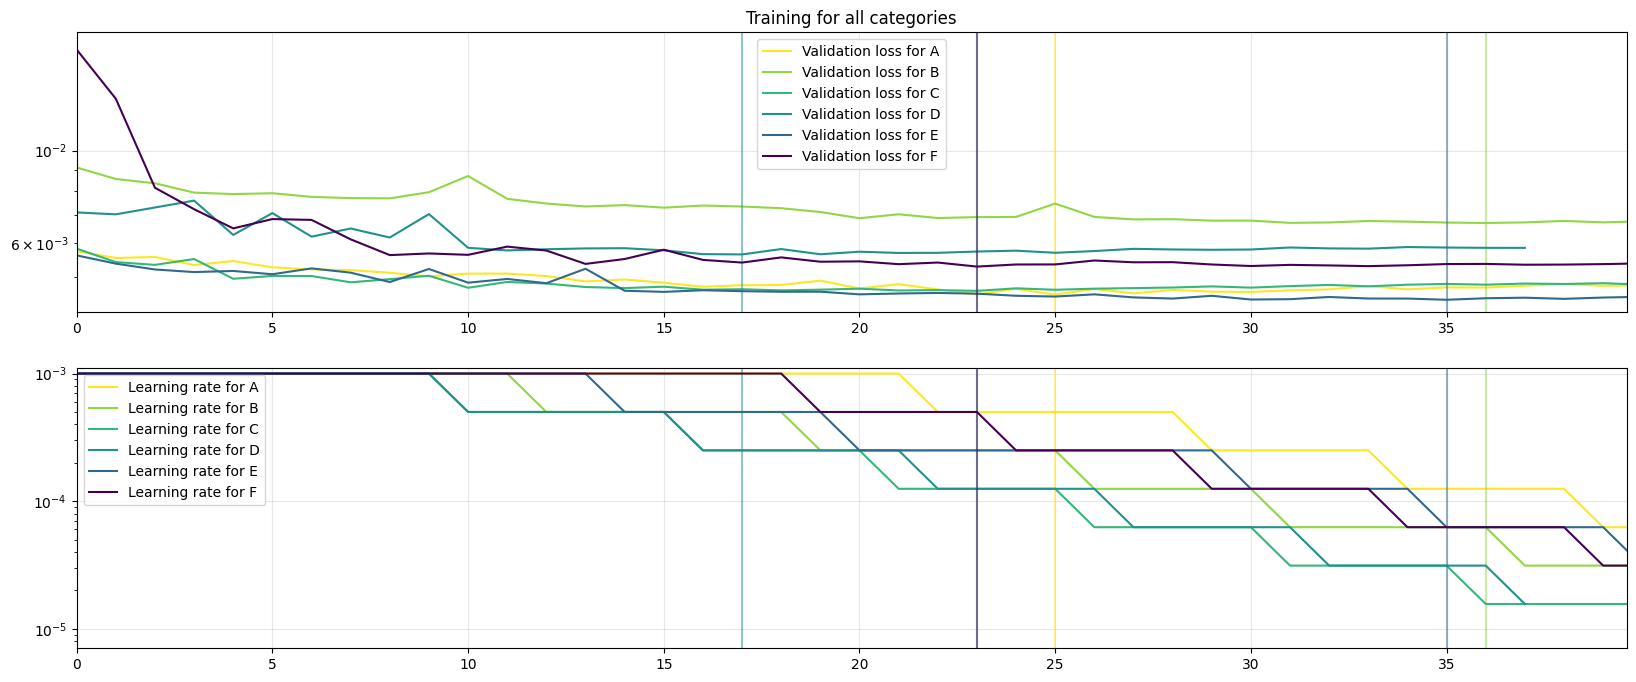

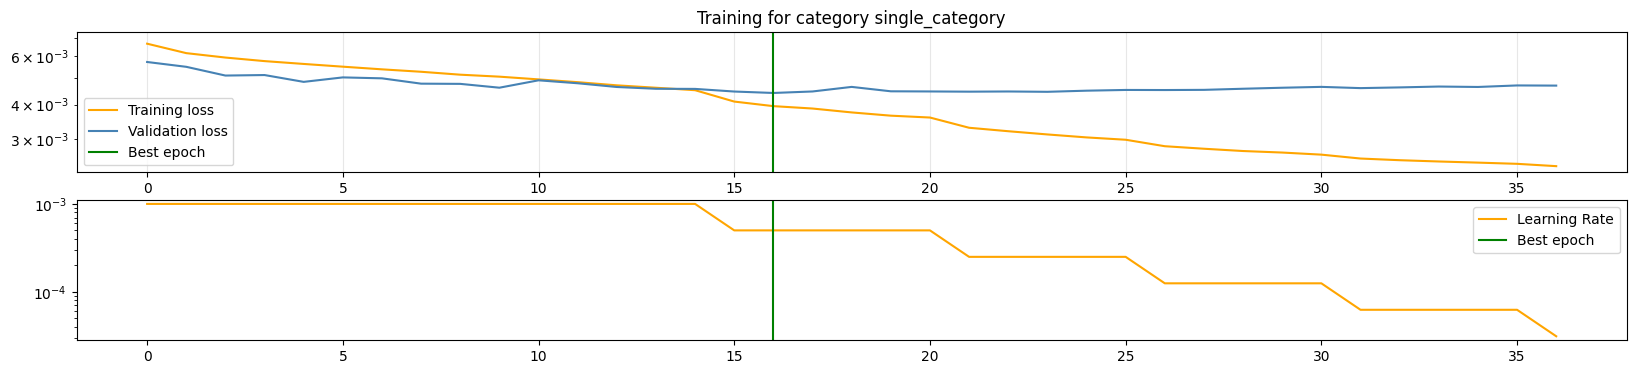

In [57]:
def plot_history(history: dict, category: str):
    best_epoch = np.argmin(history["val_loss"])
    plt.figure(figsize=(20, 4))
    # first subplot: loss and validation loss and vertical line for best epoch
    plt.subplot(2, 1, 1)
    plt.plot(history["loss"], label="Training loss", color="orange")
    plt.plot(history["val_loss"], label="Validation loss", color="steelblue")
    plt.axvline(x=best_epoch, label="Best epoch", color="green")
    plt.yscale("log")
    plt.ylim([0, max(history["loss"]) * 1.1])
    plt.title(f"Training for category {category}")
    plt.legend()
    plt.grid(alpha=0.3)
    # second subplot: learning rate and vertical line for best epoch
    plt.subplot(2,1, 2)
    plt.plot(history["lr"], label="Learning Rate", color="orange")
    plt.axvline(x=best_epoch, label="Best epoch", color="green")
    plt.yscale("log")
    plt.ylim([min(history["lr"]) * 0.9, max(history["lr"]) * 1.1])
    plt.legend()
    plt.show()


def plot_cumulative_history(history_list: list[dict]):
    # plot history for all the categories
    plt.figure(figsize=(20, 8))
    # color palette
    colors = ["#FDE725", "#90D743", "#35B779", "#21918C", "#31688E", "#440154"]
    best_epochs = [np.argmin(history["val_loss"]) for history in history_list]

    # first subplot: loss and validation loss and vertical line for best epoch
    plt.subplot(2, 1, 1)
    for x in range(len(history_list)):
        category = get_category_name(x)
        plt.plot(
            history_list[x]["val_loss"],
            label=f"Validation loss for {category}",
            color=colors[x],
        )
        plt.axvline(x=best_epochs[x], color=colors[x], alpha=0.5)
    plt.yscale("log")
    plt.grid(alpha=0.3)
    plt.ylim([0, max(max(h["val_loss"] for h in history_list)) * 1.1])
    plt.xlim([0, max(best_epochs) * 1.1])
    plt.title(f"Training for all categories")
    plt.legend()

    # second subplot: learning rate and vertical line for best epoch
    plt.subplot(2, 1, 2)
    for x in range(len(history_list)):
        category = get_category_name(x)
        plt.plot(
            history_list[x]["lr"],
            label=f"Learning rate for {category}",
            color=colors[x],
        )
        plt.axvline(x=best_epochs[x], color=colors[x], alpha=0.5)
    plt.yscale("log")
    plt.grid(alpha=0.3)
    plt.ylim(
        [
            min(min(h["lr"] for h in history_list)) * 0.9,
            max(max(h["lr"] for h in history_list)) * 1.1,
        ]
    )
    plt.xlim([0, max(best_epochs) * 1.1])
    plt.legend()

    plt.show()


# plot the history for each category
if train_class_models:
    for s in range(len(history_list)):
        plot_history(history_list[s], unique_categories[s])
    # plot the cumulative history (all categories)
    plot_cumulative_history(history_list)

# plot the history for the single category model
if train_single_model:
    plot_history(single_category_history, "single_category")

### Load Models from disk


In [17]:
# load single category models
model_list = []
history_list = []
single_category_model = None

if train_class_models:
    for c in unique_categories:
        model_path = get_model_path(c)
        model_list.append(tfk.models.load_model(model_path, compile=False))
        print(f"Model for category {c} loaded from {model_path}")

        history_path = get_history_path(c)
        with open(history_path, "r") as f:
            history_list.append(json.load(f))
        print(f"History for category {c} loaded from {history_path}")


# load single category model
if train_single_model:
    model_path = get_model_path("single_category")
    single_category_model = tfk.models.load_model(model_path, compile=False)
    print(f"Single category model loaded from {model_path}")

    history_path = get_history_path()
    with open(history_path, "r") as f:
        single_category_history = json.load(f)
    print(f"Single category history loaded from {history_path}")

Model for category A loaded from models/model_A.h5
History for category A loaded from models/history_A.json
Model for category B loaded from models/model_B.h5
History for category B loaded from models/history_B.json
Model for category C loaded from models/model_C.h5
History for category C loaded from models/history_C.json
Model for category D loaded from models/model_D.h5
History for category D loaded from models/history_D.json
Model for category E loaded from models/model_E.h5
History for category E loaded from models/history_E.json
Model for category F loaded from models/model_F.h5
History for category F loaded from models/history_F.json
Single category model loaded from models/model_single_category.h5
Single category history loaded from models/history_all.json


## Predict Test Data


In [52]:
def plot_prediction(
    x: np.array,
    y: np.array,
    predictions: np.array,
    category: str,
    title: str = None,
):
    plt.figure(figsize=(10, 5))

    plt.plot(
        x,
        color="steelblue",
        label="X train",
    )

    plt.plot(
        np.arange(window - 1, window + 2 * telescope),
        np.concatenate([x[-1:], y]),
        color="orange",
        label="Y train",
    )

    plt.plot(
        np.arange(window - 1, window + 2 * telescope),
        np.concatenate([x[-1:], predictions]),
        color="green",
        label="Predicted",
    )

    plt.ylim([0, max(max(y), max(predictions)) * 1.1])

    if title is None:
        plt.title(f"Category {category}")
    else:
        plt.title(title)

    plt.legend()
    plt.show()


def evaluate_model(
    model: tfk.Model,
    category: str,
) -> tuple[float, float, np.array]:
    X_test = dataset[category]["X_test"]
    Y_test = dataset[category]["Y_test"]

    # auto regressive prediction
    # predict the first telescope values
    y1 = np.expand_dims(model.predict(X_test, verbose=False), axis=-1)
    # concatenate the predictions to the input
    x2 = np.concatenate([X_test[:, telescope:], y1], axis=1)
    # predict the second telescope values
    y2 = np.expand_dims(model.predict(x2, verbose=False), axis=-1)
    # concatenate the predictions
    predictions = np.concatenate([y1, y2], axis=1)

    # compute the mean squared error (MSE)
    mse = tfk.losses.mean_squared_error(
        Y_test.flatten(),
        predictions.flatten(),
    ).numpy()
    # compute the mean absolute error (MAE)
    mae = tfk.losses.mean_absolute_error(
        Y_test.flatten(),
        predictions.flatten(),
    ).numpy()

    return mse, mae, predictions

### Evaluate Models

#### Evaluate models on each category

Here we evaluate the models on each category and plot the results. We also compute MSE and MAE for each category.

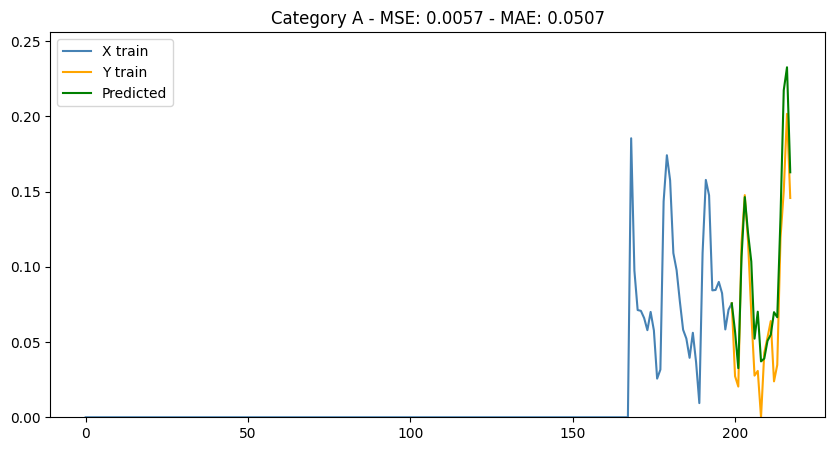

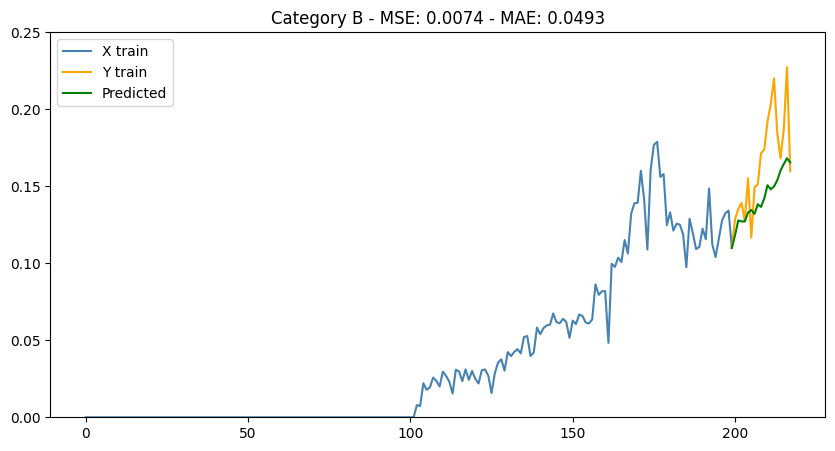

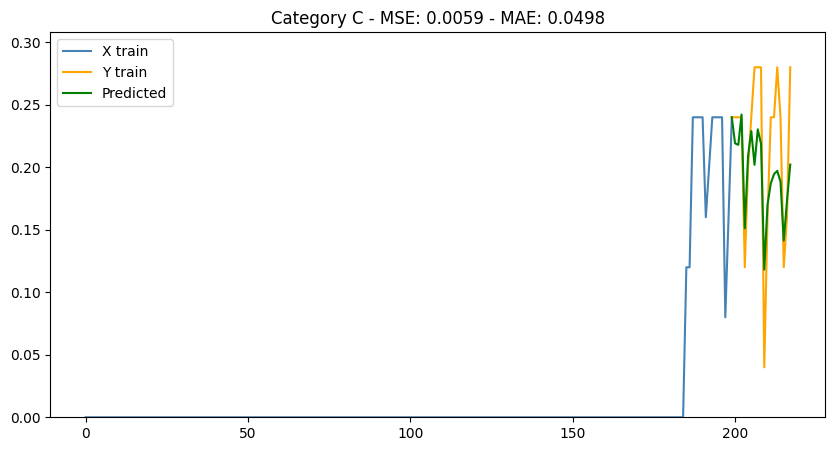

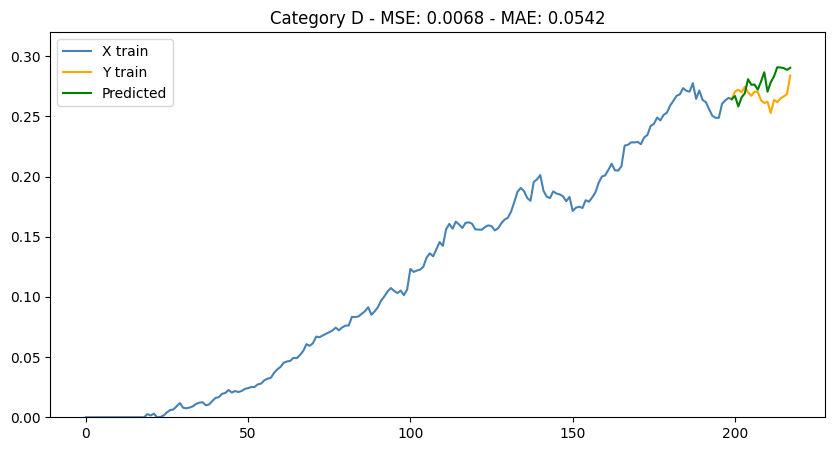

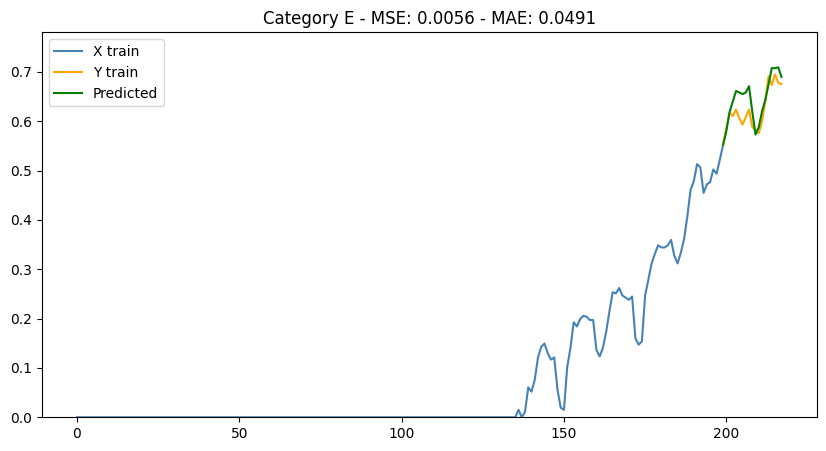

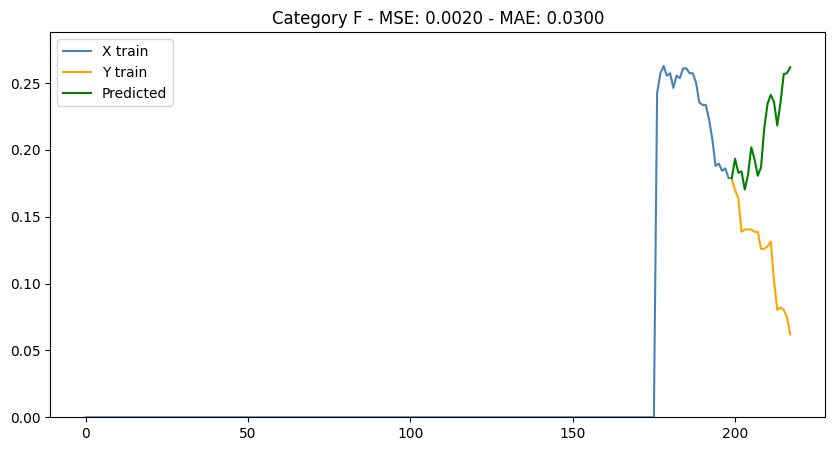

In [53]:
# Evaluate the models for each category
mse_list, mae_list, predictions_list = [], [], []

if train_class_models:
    for i, category in enumerate(unique_categories):
        # evaluate the model
        avg_mse, avg_mae, predictions = evaluate_model(
            model_list[i],
            category,
        )
        # append the results to the lists
        mse_list.append(avg_mse)
        mae_list.append(avg_mae)
        predictions_list.append(predictions)

        # plot a random prediction
        title = f"Category {category} - MSE: {avg_mse:.4f} - MAE: {avg_mae:.4f}"
        index = random.randint(0, len(dataset[category]["X_test"]))
        plot_prediction(
            dataset[category]["X_test"][index],
            dataset[category]["Y_test"][index],
            predictions[index],
            category,
            title,
        )

#### Evaluate single category model

Here we evaluate the single category model over the complete dataset and plot the results. We also compute MSE and MAE for the whole dataset.

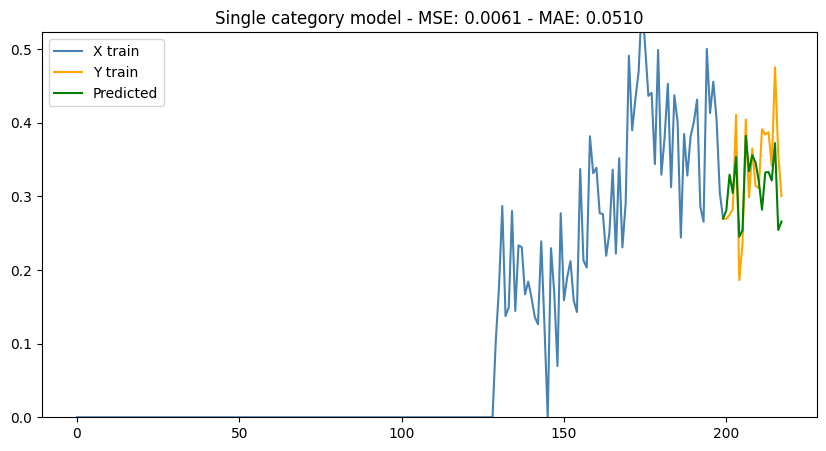

In [56]:
# Evaluate the single category model
single_mse, single_mae, single_predictions = None, None, None
if train_single_model:
    # evaluate the model
    single_mse, single_mae, single_predictions = evaluate_model(
        single_category_model,
        "single_category",
    )

    # plot a random prediction
    title = f"Single category model - MSE: {single_mse:.4f} - MAE: {single_mae:.4f}"
    index = random.randint(0, len(dataset["single_category"]["X_test"]))
    plot_prediction(
        dataset["single_category"]["X_test"][index],
        dataset["single_category"]["Y_test"][index],
        single_predictions[index],
        "single_category",
        title,
    )

    # compute the weighted average MSE and MAE over the number of samples in each category
    avg_mse = np.sqrt(
        np.average(
            mse_list, weights=[len(dataset[c]["X_test"]) for c in unique_categories]
        )
    )
    avg_mae = np.average(
        mae_list, weights=[len(dataset[c]["X_test"]) for c in unique_categories]
    )

### Compare Single category and Multi category Predictions

In [44]:
if train_single_model and train_class_models:
    print(f"Single category model: MSE = {single_mse}, MAE = {single_mae}")
    print(f"Weighted average: MSE = {avg_mse}, MAE = {avg_mae}")

    # compute the relative error between the single category model and the weighted average
    mse_error = 100 * (avg_mse / single_mse)
    mae_error = 100 * (avg_mae / single_mae)

    print(f"Relative error: MSE = {mse_error:.2f}%, MAE = {mae_error:.2f}%")

Single category model: MSE = 0.006120461504906416, MAE = 0.05100957304239273
Weighted average: MSE = 0.07900352576353162, MAE = 0.05077166893561425
Relative error: MSE = 1290.81%, MAE = 99.53%


In [45]:
if train_single_model and train_class_models:
    better_single, better_category = [], []
    for i, category in enumerate(unique_categories):
        # check if the single category model is better than the category model
        if avg_mse < mse_list[i]:
            better_single.append(category)
        else:
            better_category.append(category)

    print(f"Single category model is better for categories: {better_single}")
    print(f"Category model is better for categories: {better_category}")

Single category model is better for categories: []
Category model is better for categories: ['A', 'B', 'C', 'D', 'E', 'F']
